# WaveformAnalysis 入门教程

本教程将带你了解 WaveformAnalysis 波形数据分析工具包的基本用法。

## 核心概念

| 概念 | 说明 |
|------|------|
| **Context** | 插件系统调度器，管理依赖、配置、缓存 |
| **Plugin** | 数据处理单元，每个插件负责一种数据转换 |
| **Lineage** | 自动血缘追踪，确保缓存一致性 |

## 数据处理流程

```
raw_files → waveforms → st_waveforms → basic_features
```

- `raw_files`: 原始 DAQ 文件路径
- `waveforms`: 从文件中提取的波形数据
- `st_waveforms`: 结构化波形（带时间戳、通道信息）
- `basic_features`: 基础特征（height, area 等）

## 0 查看数据


In [23]:
from waveform_analysis import DAQAnalyzer

da = DAQAnalyzer(daq_root="/mnt/data/Run3/DAQ", daq_adapter="vx2730")
da.scan_all_runs().display_overview()

运行名称,文件数,大小(MB),大小,通道数,通道列表,路径
45V_OV_circulation_CH0_Coincidence_20dB,7,4448.09,4.34 GB,3,"0, 2, 3",/mnt/data/Run3/DAQ/45V_OV_circulation_CH0_Coincidence_20dB
46V_OV_circulation_CH0_Coincidence_20dB,7,4463.57,4.36 GB,3,"0, 2, 3",/mnt/data/Run3/DAQ/46V_OV_circulation_CH0_Coincidence_20dB
47V_OV_circulation_CH0_Coincidence_20dB,7,4471.24,4.37 GB,3,"0, 2, 3",/mnt/data/Run3/DAQ/47V_OV_circulation_CH0_Coincidence_20dB
48V_OV_circulation_CH0_Coincidence_20dB,20,19253.28,18.80 GB,3,"0, 2, 3",/mnt/data/Run3/DAQ/48V_OV_circulation_CH0_Coincidence_20dB
49V_OV_circulation_20thr,7,5742.33,5.61 GB,2,"6, 7",/mnt/data/Run3/DAQ/49V_OV_circulation_20thr
49V_OV_circulation_CH0_Coincidence,0,0.00,0.00 B,0,-,/mnt/data/Run3/DAQ/49V_OV_circulation_CH0_Coincidence
49V_OV_circulation_CH0_Coincidence_20dB,15,12136.51,11.85 GB,3,"0, 2, 3",/mnt/data/Run3/DAQ/49V_OV_circulation_CH0_Coincidence_20dB
49V_OV_circulation_CH0_Coincidence_27dB,4,2117.15,2.07 GB,3,"0, 2, 3",/mnt/data/Run3/DAQ/49V_OV_circulation_CH0_Coincidence_27dB
50V_OV_circulation_20thr,6,5655.19,5.52 GB,2,"6, 7",/mnt/data/Run3/DAQ/50V_OV_circulation_20thr
50V_over_voltage,17,16127.07,15.75 GB,2,"6, 7",/mnt/data/Run3/DAQ/50V_over_voltage


## 1. 导入库

In [ ]:
import matplotlib.pyplot as plt

from waveform_analysis.core.context import Context
from waveform_analysis.core.plugins.builtin.cpu import (
    BasicFeaturesPlugin,
    RawFileNamesPlugin,
    StWaveformsPlugin,
    WaveformsPlugin,
)

# 设置 matplotlib 中文显示
plt.rcParams["font.sans-serif"] = ["SimHei", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

## 2. 创建 Context 并注册插件

Context 是整个分析框架的核心，负责：
- 管理插件注册
- 解析依赖关系
- 分发配置
- 管理数据缓存

In [8]:
# 创建 Context 实例
ctx = Context(storage_dir="./strax_data")

# 注册基础插件（按依赖顺序）
ctx.register(
    RawFileNamesPlugin(),
    WaveformsPlugin(),
    StWaveformsPlugin(),
    BasicFeaturesPlugin(),
)

# 设置配置
ctx.set_config({
    "data_root": "/mnt/data/Run3/DAQ",  # DAQ 数据根目录
    "daq_adapter": "vx2730",  # DAQ 适配器类型
    "n_channels": 2,  # 通道数
    "show_progress": True,  # 显示进度条
})

print("Context 创建成功！")

Context 创建成功！


## 3. 获取数据

使用 `ctx.get_data(run_id, data_name)` 获取数据。

Context 会自动：
1. 解析依赖关系
2. 按顺序执行所需插件
3. 缓存中间结果

In [25]:
# 指定运行名称（对应 DAQ 目录下的子目录）
run_id = "Argon_w4_o3_Window_27dB_75LSB_annode0_cathode0"

# 获取结构化波形数据
print(f"正在处理: {run_id}")
st_waveforms = ctx.get_data(run_id, "st_waveforms")

print(f"\n通道数: {len(st_waveforms)}")
for ch_idx, ch_data in enumerate(st_waveforms):
    if len(ch_data) > 0:
        print(f"通道 {ch_idx}: {len(ch_data)} 个事件")

正在处理: Argon_w4_o3_Window_27dB_75LSB_annode0_cathode0
[+] Running plugin: raw_files (run_id: Argon_w4_o3_Window_27dB_75LSB_annode0_cathode0)
[+] Running plugin: waveforms (run_id: Argon_w4_o3_Window_27dB_75LSB_annode0_cathode0)
[+] Running plugin: st_waveforms (run_id: Argon_w4_o3_Window_27dB_75LSB_annode0_cathode0)



通道数: 4
通道 2: 15930 个事件
通道 3: 23396 个事件


In [26]:
ctx.get_data(run_id, "raw_files")

[[],
 [],
 ['/mnt/data/Run3/DAQ/Argon_w4_o3_Window_27dB_75LSB_annode0_cathode0/RAW/DataR_CH2@VX2730_53013_Argon_w4_o3_Window_27dB_75LSB_annode0_cathode0.CSV'],
 ['/mnt/data/Run3/DAQ/Argon_w4_o3_Window_27dB_75LSB_annode0_cathode0/RAW/DataR_CH3@VX2730_53013_Argon_w4_o3_Window_27dB_75LSB_annode0_cathode0.CSV']]

## 4. 查看数据结构

结构化数组使用 NumPy 的 structured array，可以通过字段名访问数据。

In [27]:
# 查看 st_waveforms 的数据结构
if len(st_waveforms) > 0 and len(st_waveforms[0]) > 0:
    print("st_waveforms 字段:")
    print(st_waveforms[0].dtype.names)
    print("\n第一个事件示例:")
    print(f"  时间戳: {st_waveforms[0][0]['time']}")
    print(f"  波形长度: {len(st_waveforms[0][0]['wave'])}")

In [28]:
# 获取基础特征
basic_features = ctx.get_data(run_id, "basic_features")

print("basic_features 字段:")
if len(basic_features) > 0 and len(basic_features[0]) > 0:
    print(basic_features[0].dtype.names)

# 提取 height 和 area
heights = [ch["height"] for ch in basic_features if len(ch) > 0]
areas = [ch["area"] for ch in basic_features if len(ch) > 0]

print(f"\n提取到 {len(heights)} 个通道的 height 数据")
print(f"提取到 {len(areas)} 个通道的 area 数据")

[+] Running plugin: basic_features (run_id: Argon_w4_o3_Window_27dB_75LSB_annode0_cathode0)
basic_features 字段:

提取到 2 个通道的 height 数据
提取到 2 个通道的 area 数据


## 5. 波形可视化

In [29]:
# 绘制单个波形
channel_idx = 0
event_idx = 0

if len(st_waveforms) > channel_idx and len(st_waveforms[channel_idx]) > event_idx:
    waveform = st_waveforms[channel_idx][event_idx]["wave"]

    plt.figure(figsize=(10, 4))
    plt.plot(waveform, "b-", linewidth=0.8)
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.title(f"Waveform - Channel {channel_idx}, Event {event_idx}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [30]:
# 绘制多个波形对比
n_events = min(5, len(st_waveforms[0]) if len(st_waveforms) > 0 else 0)

if n_events > 0:
    fig, axes = plt.subplots(n_events, 1, figsize=(10, 2 * n_events), sharex=True)
    if n_events == 1:
        axes = [axes]

    for i in range(n_events):
        waveform = st_waveforms[0][i]["wave"]
        axes[i].plot(waveform, "b-", linewidth=0.8)
        axes[i].set_ylabel(f"Event {i}")
        axes[i].grid(True, alpha=0.3)

    axes[-1].set_xlabel("Sample")
    fig.suptitle("Waveform Comparison - Channel 0", y=1.02)
    plt.tight_layout()
    plt.show()

## 6. 配置管理

Context 提供了丰富的配置管理功能。

In [31]:
# 查看所有插件的可用配置选项
ctx.list_plugin_configs()


📦 插件概览


,class,version,description,options,modified
plugin,,,,,
raw_files,RawFileNamesPlugin,0.0.2,Scan the data directory and group raw CSV file...,2,1
basic_features,BasicFeaturesPlugin,0.0.0,,3,0
st_waveforms,StWaveformsPlugin,0.0.0,,2,0
waveforms,WaveformsPlugin,0.0.2,Read and parse waveform data from raw CSV files.,6,0



⚙️ 配置选项明细


{'raw_files': {'class': 'RawFileNamesPlugin',
  'description': 'Scan the data directory and group raw CSV files by channel number.',
  'version': '0.0.2',
  'options': {'data_root': {'default': 'DAQ',
    'type': 'str',
    'help': 'Root directory for data',
    'track': True,
    'current_value': '/mnt/data/Run3/DAQ',
    'is_default': False},
   'daq_adapter': {'default': 'vx2730',
    'type': 'str',
    'help': "DAQ adapter name (e.g., 'vx2730')",
    'track': True,
    'current_value': 'vx2730',
    'is_default': True}}},
 'waveforms': {'class': 'WaveformsPlugin',
  'description': 'Read and parse waveform data from raw CSV files.',
  'version': '0.0.2',
  'options': {'channel_workers': {'default': None,
    'type': 'Any',
    'help': 'Number of parallel workers for channel-level processing (None=auto, uses min(len(raw_files), cpu_count))',
    'track': False,
    'current_value': None,
    'is_default': True},
   'channel_executor': {'default': 'thread',
    'type': 'str',
    'hel

In [32]:
# 查看当前配置
ctx.show_config()


配置概览
缓存目录: /mnt/data/Run3/wa-plugins/strax_data/Argon_w4_o3_Window_27dB_75LSB_annode0_cathode0/_cache
全局配置项: 2  插件特定配置: 0  未使用配置: 5

📦 全局配置项


,value,used_by
key,,
daq_adapter,'vx2730',"'raw_files, waveforms, st_waveforms'"
data_root,'/mnt/data/Run3/DAQ','raw_files'



⚠️ 未使用配置


,value,note
key,,
auto_extract_epoch,True,未被任何已注册插件使用
epoch_extraction_strategy,'auto',未被任何已注册插件使用
epoch_filename_patterns,None,未被任何已注册插件使用
n_channels,2,未被任何已注册插件使用
show_progress,True,未被任何已注册插件使用


In [33]:
# 修改配置示例
# ctx.set_config({'threshold': 20.0})  # 全局配置
# ctx.set_config({'threshold': 20.0}, plugin_name='basic_features')  # 插件特定配置

## 7. 血缘可视化

血缘图展示数据之间的依赖关系，帮助理解数据处理流程。

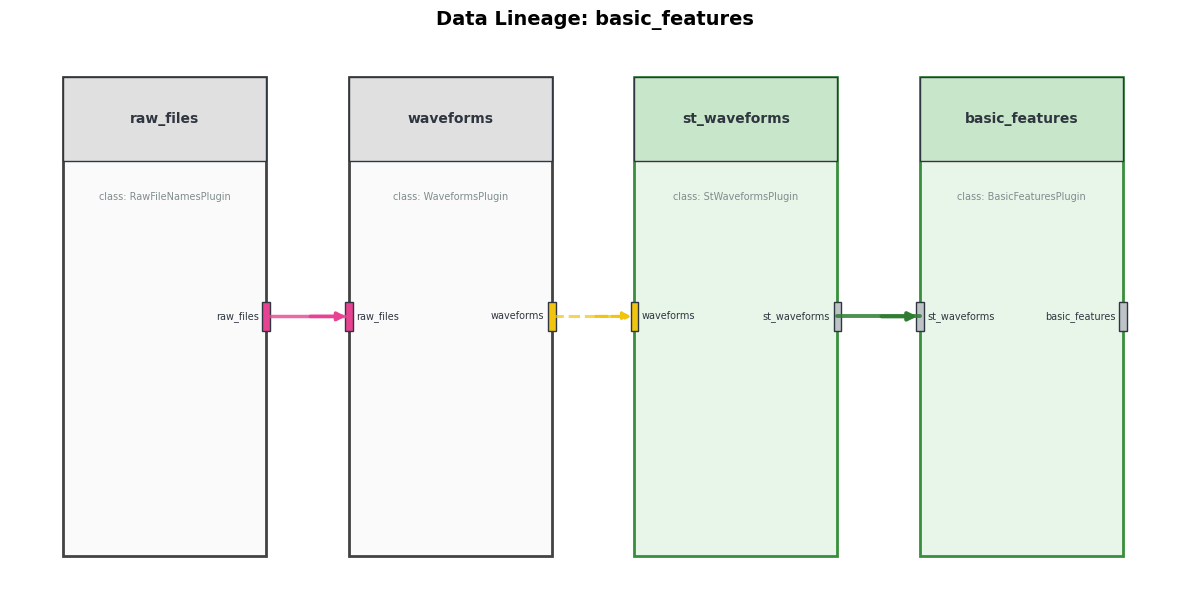

In [34]:
# 可视化 basic_features 的数据依赖关系
ctx.plot_lineage("basic_features", kind="labview")

## 8. 预览执行计划

在实际执行前，可以预览执行计划和缓存状态。

In [36]:
# 预览执行计划（不实际执行）
ctx.preview_execution(run_id, "basic_features")


执行计划预览: basic_features (run_id: Argon_w4_o3_Window_27dB_75LSB_annode0_cathode0)

📋 执行计划:
  共 4 个步骤
  ├─→ 1. raw_files ✓ [内存]
  ├─→ 2. waveforms ✓ [内存]
  ├─→ 3. st_waveforms ✓ [内存]
  └─→ 4. basic_features ✓ [内存]

🌳 依赖关系树:
  └─ basic_features
     └─ st_waveforms
        └─ waveforms
           └─ raw_files

⚙️ 自定义配置:
  • raw_files:
      data_root = /mnt/data/Run3/DAQ

💾 缓存状态汇总:
  • 内存缓存: 4 个
  • 磁盘缓存: 0 个
  • 需要计算: 0 个
  • 已剪枝: 0 个




{'target': 'basic_features',
 'run_id': 'Argon_w4_o3_Window_27dB_75LSB_annode0_cathode0',
 'execution_plan': ['raw_files',
  'waveforms',
  'st_waveforms',
  'basic_features'],
 'cache_status': {'raw_files': {'in_memory': True,
   'on_disk': False,
   'needs_compute': False,
   'pruned': False},
  'waveforms': {'in_memory': True,
   'on_disk': False,
   'needs_compute': False,
   'pruned': False},
  'st_waveforms': {'in_memory': True,
   'on_disk': True,
   'needs_compute': False,
   'pruned': False},
  'basic_features': {'in_memory': True,
   'on_disk': True,
   'needs_compute': False,
   'pruned': False}},
 'configs': {'raw_files': {'data_root': {'value': '/mnt/data/Run3/DAQ',
    'default': 'DAQ',
    'type': 'str'}}},
 'resolved_depends_on': {'raw_files': [],
  'waveforms': ['raw_files'],
  'st_waveforms': ['waveforms'],
  'basic_features': ['st_waveforms']},
 'needed_set': []}

## 总结
### 核心 API
| 方法 | 说明 |
|------|------|
| `ctx.register(*plugins)` | 注册插件 |
| `ctx.set_config(config)` | 设置配置 |
| `ctx.get_data(run_id, data_name)` | 获取数据 |
| `ctx.show_config()` | 查看当前配置 |
| `ctx.list_plugin_configs()` | 列出所有插件配置选项 |
| `ctx.plot_lineage(data_name)` | 可视化数据血缘 |
| `ctx.preview_execution(run_id, data_name)` | 预览执行计划 |
### 下一步学习
- [示例代码](docs/user-guide/EXAMPLES_GUIDE.md) - 更多使用场景
- [配置管理](docs/features/context/CONFIGURATION.md) - 配置选项说明
- [数据访问](docs/features/context/DATA_ACCESS.md) - 数据获取详解
